In [ ]:
import sys
# from google.colab import drive
# drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/SemEval')

In [ ]:
# !pip install sentencepiece

# !pip install transformers[torch]

In [ ]:
!nvidia-smi

Tue Dec 19 16:12:39 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# from helpers import load_data, get_text_len
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
import json
from torch.optim import AdamW
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

In [ ]:
# Load model directly
from transformers import XLNetForSequenceClassification, XLNetTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification

# #XL NET MODEL
xl_net_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)
xl_net_tokenizer =  XLNetTokenizer.from_pretrained('xlnet-base-cased')


In [ ]:
train_fp = '/content/drive/My Drive/SemEval/data/train_monolingual.jsonl'
dev_fp = '/content/drive/My Drive/SemEval/data/dev_monolingual.jsonl'

In [ ]:

def load_data(file_path):
  texts = []
  labels = []
  with open(file_path, 'r') as f:
      for line in f:
        data = json.loads(line)
        texts.append(data['text'])
        labels.append(data['label'])
  return texts, labels




In [ ]:
train_texts, train_labels = load_data(train_fp)
dev_texts, dev_labels = load_data(dev_fp)

In [ ]:
# print(len(train_texts))
# print(len(validation_texts))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.1, random_state=12, shuffle=True)
print(f"X_train: {len(X_train)}")
print(f"X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}")
print(f"y_test: {len(y_test)}")

In [ ]:
#Tokenize Data
folder = 'test_train_split'
xl_train_path = f'/content/drive/My Drive/SemEval/data/{folder}/xl_net_tokenized_train.pth'

xl_all_train_path = f'/content/drive/My Drive/SemEval/data/{folder}/xl_net_tokenized_final_train.pth'

# xl_net_tokenized_final_train_data = xl_net_tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
# torch.save(xl_net_tokenized_final_train_data, xl_all_train_path)
#XL Net tokenized training data
# xl_net_tokenized_train_data = xl_net_tokenizer(X_train, padding=True, truncation=True, max_length=512, return_tensors='pt')
# torch.save(xl_net_tokenized_train_data, xl_train_path)

# XL net tokenized validation data
# xl_net_tokenized_dev_data = xl_net_tokenizer(X_test, padding=True, truncation=True, max_length=512, return_tensors='pt')
# torch.save(xl_net_tokenized_dev_data, xl_dev_path)


In [ ]:
xl_dev_path = f'/content/drive/My Drive/SemEval/data/test_train_split/xl_net_tokenized_final_dev.pth'


In [ ]:
#loading data for later training

xl_net_tokenized_train_data = torch.load(xl_train_path)
xl_net_tokenized_final_train_data = torch.load(xl_all_train_path)
xl_net_tokenized_dev_data = torch.load(xl_dev_path)
print("done")


In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
      item = {key: val[idx] for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

    def __len__(self):
        return len(self.labels)

In [ ]:
xl_net_train_dataset = TextDataset(xl_net_tokenized_train_data, y_train)
xl_net_final_train_dataset = TextDataset(xl_net_tokenized_final_train_data, train_labels)
# xl_net_validation_dataset = TextDataset(xl_net_tokenized_validation_data, y_test)

In [ ]:
xl_net_dev_dataset = TextDataset(xl_net_tokenized_dev_data,dev_labels)

In [ ]:
model_name = 'xl_net'
version = 'final_training_2'
output_directory = f'/content/drive/My Drive/SemEval/trainer_models/{model_name}/{version}/results/'
logging_directory = f'/content/drive/My Drive/SemEval/trainer_models/{model_name}/{version}/logs/'

In [ ]:



current_model = xl_net_model
current_train_data = xl_net_train_dataset
current_validation_data = xl_net_dev_dataset


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import logging
import csv
import os

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



In [ ]:
from transformers import TrainerCallback


class LoggingCallback(TrainerCallback):
    def __init__(self, train_log_file, eval_log_file):
        self.train_log_file = train_log_file
        self.eval_log_file = eval_log_file

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and 'loss' in logs:
            with open(self.train_log_file, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([state.global_step, logs['loss']])

    def on_evaluate(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and logs is not None and 'eval_loss' in logs:
            with open(self.eval_log_file, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([state.global_step, logs['eval_loss']])


In [ ]:
train_log_file = f'{logging_directory}training_loss.csv'
eval_log_file = f'{logging_directory}eval_loss.csv'

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback



logging_callback = LoggingCallback(train_log_file, eval_log_file)
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=10)

training_args = TrainingArguments(
    output_dir=output_directory,
    num_train_epochs=1,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_directory,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False
)

trainer = Trainer(
    model=current_model,
    args=training_args,
    train_dataset=current_train_data,
    eval_dataset=current_validation_data,
    compute_metrics=compute_metrics,
    callbacks=[logging_callback, early_stopping_callback]
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.665800,0.688375,0.549800,0.471472,0.570779,0.401600
200,0.467700,0.726737,0.615800,0.572636,0.645113,0.514800
300,0.277100,0.633250,0.746200,0.767880,0.707449,0.839600
400,0.173600,0.749473,0.758400,0.797111,0.687030,0.949200
500,0.165700,0.579474,0.779400,0.807269,0.716724,0.924000
600,0.139400,0.550300,0.789600,0.782555,0.809666,0.757200
700,0.127300,0.807563,0.763600,0.786257,0.717492,0.869600
800,0.122600,0.648468,0.773400,0.802716,0.710762,0.922000
900,0.110200,0.542831,0.816800,0.811056,0.837308,0.786400
1000,0.098500,0.618500,0.796600,0.819713,0.736071,0.924800


In [ ]:
trainer.evaluate()

In [ ]:
current_model.save_pretrained(output_directory + 'final_model')
current_tokenizer.save_pretrained(output_directory + 'final_model')

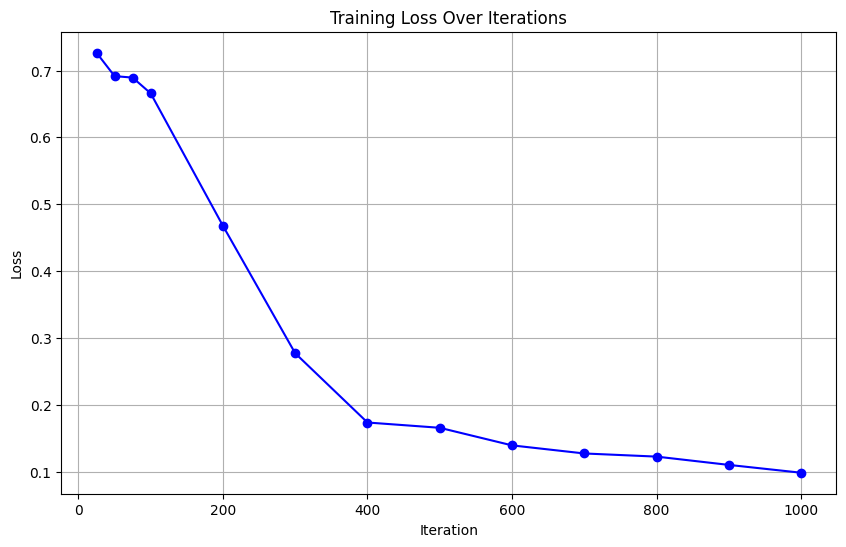

In [ ]:
training_loss_data = pd.read_csv(train_log_file)

training_loss_data.columns = ['Iteration', 'Loss']

plt.figure(figsize=(10, 6))
plt.plot(training_loss_data['Iteration'], training_loss_data['Loss'], marker='o', color='b')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
train_log_file

# Training f1, accuracy, precision and recall

In [ ]:
test_loss_data = pd.read_csv(eval_log_file)

test_loss_data.columns = ['Iteration', 'Loss']

plt.figure(figsize=(10, 6))
plt.plot(test_loss_data['Iteration'], test_loss_data['Loss'], marker='o', color='b')
plt.title('Eval Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# current_model.save_pretrained(output_directory + 'final_model')
# current_tokenizer.save_pretrained(output_directory + 'final_model')

In [ ]:
predictions_output = trainer.predict(xl_net_dev_dataset)


In [ ]:
predictions = np.argmax(predictions_output.predictions, axis=1)


# Dev data set score

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(dev_labels, predictions, average='binary')
acc = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Accuracy: 0.8048

Precision: 0.7506578947368421

Recall: 0.9128

F1: 0.823826714801444

In [ ]:
ids = range(0, len(dev_labels))

# Now create the DataFrame
pred_df = pd.DataFrame({'id': ids, 'label': dev_labels, 'predictions': predictions})

In [ ]:
pred_file = logging_directory +'/dev_predictions.csv'
pred_df.to_csv(pred_file, index=False)

In [ ]:


train_predictions_output = trainer.predict(xl_net_final_train_dataset)
train_predictions = np.argmax(train_predictions_output.predictions, axis=1)

In [ ]:
ids = range(0, len(train_labels))

# Now create the DataFrame
pred_df = pd.DataFrame({'id': ids, 'label': train_labels, 'predictions': train_predictions})

In [ ]:
pred_df

In [ ]:
pred_file = logging_directory +'/train_predictions.csv'
pred_df.to_csv(pred_file, index=False)